In [26]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import joblib
from numpy import where
import missingno as msno
import seaborn as sns
import numpy as np
import json
import time
import os

In [43]:
# =============================
# == Segment 1: Data Loading ==
# =============================

# Load the CSV file into a DataFrame
df = pd.read_csv("hotel_bookings.csv")
num_samples, num_features = df.shape
print(f"Dataset has {num_samples:,} samples and {num_features} features")

# ==================================
# == Segment 2: Remove Duplicates ==
# ==================================

# Check number of duplicates while ignoring the is_canceled feature
n_duplicates = df.drop(labels=["is_canceled"], axis=1).duplicated().sum()
print(f"There are {n_duplicates} duplicates in the database. which is {round((n_duplicates/num_samples)*100,1)}%")
#  Extract column names of all features, except 'is_canceled'
columns_to_consider = df.drop(labels=["is_canceled"], axis=1).columns
# Drop duplicates based on 'columns_to_consider'
df.drop_duplicates(subset=columns_to_consider,inplace=True)
num_samples, num_features = df.shape
print(f"Dataset has {num_samples:,} samples and {num_features} features after removing duplicates")


# ======================================
# == Segment 3: Train test split data ==
# ======================================

# Separating features (X) and target (Y)
X = df.drop(columns=['is_canceled'])  # Features (X)
Y = df['is_canceled']  # Target (Y)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# =================================================
# == Segment 4: Preprocess data
# =================================================

# Catcategorical variables mapping
def map_categorical_columns(df, directory='json'):
    # Function to load mappings from JSON files
    def load_mappings_from_directory(directory):
        mappings = {}
        for filename in os.listdir(directory):
            if filename.endswith(".json"):
                column_name = os.path.splitext(filename)[0]
                with open(os.path.join(directory, filename), 'r') as f:
                    mappings[column_name] = json.load(f)
        return mappings

    # Load mappings
    mappings = load_mappings_from_directory(directory)

    # Function to map categorical column
    def map_categorical_column(value, mapping):
        return mapping.get(value, value)

    # Map categorical columns
    df_mapped = df.copy()
    for column, mapping in mappings.items():
        df_mapped[column] = df_mapped[column].apply(lambda x: map_categorical_column(x, mapping))

    return df_mapped

#Feature Engineering
def transform_date_feature(df):
    X_copy=df.copy()
    X_copy['arrival_date'] = pd.to_datetime(X_copy['arrival_date_year'].astype(str) + '-' + X_copy['arrival_date_month'] + '-' + X_copy['arrival_date_day_of_month'].astype(str), format='%Y-%B-%d')
    X_copy['arrival_date_month'] = X_copy['arrival_date_month'].apply(lambda x: datetime.strptime(x, "%B").month)
    X_copy['reservation_status_date'] = pd.to_datetime(X_copy['reservation_status_date'])
    return X_copy

def featuredrop(df):
    X_copy=df.copy()
    X_copy.drop(columns=['arrival_date_year', 'arrival_date_week_number'], inplace=True)
    X_copy.drop(columns=['reservation_status_date', 'arrival_date'], inplace=True)
    X_copy.drop(columns=['agent','company'], inplace=True) #Removing agent and company column as they reprent Agent or company ID
    return X_copy


#Missing Values Check
def impute_missing_values(df):
    missing_values_info = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': round((df.isnull().sum() / len(df)) * 100,3)
    })
    # Filter columns with missing values
    missing_values_info = missing_values_info[missing_values_info['Missing Count'] > 0]
    # Print the table
    print("Columns with missing values:\n", missing_values_info)
    #imputing missing values using knn
    imputer = KNNImputer(n_neighbors=4)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed

def updateDataTypes(df):
    df2=df.copy()
    # Converting datatype of columns 'children', 'company' and 'agent' from float to int.
    df2[['children']] = df2[['children']].astype('int64')
    return df2

def normalisation(df):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    # Fit and transform the DataFrame
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return normalized_df

def outlier_removal(X,Y):
    from sklearn.ensemble import IsolationForest

    IF_classifier = IsolationForest(n_estimators  = 2000,
                                    contamination = 0.05,
                                    random_state  = 42)

    y_pred_IF = IF_classifier.fit_predict(X)

    X_train_filtered, y_train_filtered = X[(y_pred_IF == 1)], Y[(y_pred_IF == 1)]
    #outlier_index = where(y_pred_IF==-1)
    #values = X.iloc[outlier_index]
    #plt.scatter(X.iloc[:,0], X.iloc[:,1])
    #plt.scatter(values.iloc[:,0], values.iloc[:,1], label='Outliers', color='red')
    #plt.show()

    rows_before_filtering = X.shape[0]
    rows_after_filtering = X_train_filtered.shape[0]
    print("N rows dropped using iForest = ", rows_before_filtering - rows_after_filtering)

    return X_train_filtered, y_train_filtered

def Feature_Balance(df,Y):
    def check_imbalance(Y,state):
        # Check imbalance in the target variable
        cancelled_count = Y.sum()
        not_cancelled_count = Y.shape[0] - cancelled_count
        print(state)
        print("Cancelled bookings count:", cancelled_count)
        print("Not Cancelled bookings count:", not_cancelled_count)
        # Calculate imbalance ratio
        imbalance_ratio = cancelled_count / not_cancelled_count
        print("Imbalance ratio:", imbalance_ratio)
    check_imbalance(Y,"Before SMOTE:")
    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_resampled, Y_resampled = smote.fit_resample(df, Y)
    check_imbalance(Y_resampled,"After SMOTE:")
    return X_resampled, Y_resampled
    

def PreprocessData(df,Y):
    df1=map_categorical_columns(df)
    df2=transform_date_feature(df1)
    df2=featuredrop(df2)
    df3=impute_missing_values(df2)
    df5=updateDataTypes(df3)
    df4=normalisation(df5)
    X,Y=outlier_removal(df4,Y)
    X1,Y1=Feature_Balance(X,Y)
    return X1, Y1
    


Dataset has 119,390 samples and 32 features
There are 31994 duplicates in the database. which is 26.8%
Dataset has 87,396 samples and 32 features after removing duplicates


In [44]:
# Fit and transform the training data
X_train_transformed,y_train, = PreprocessData(X_train,y_train)
print('x_train_shape',X_train_transformed.shape)

# Transform the test data
X_test_transformed,y_test = PreprocessData(X_test,y_test)
print('x_test_shape',X_test_transformed.shape)


Columns with missing values:
           Missing Count  Missing Percentage
children              2                0.00
country             319                0.52
N rows dropped using iForest =  3059
Before SMOTE:
Cancelled bookings count: 16002
Not Cancelled bookings count: 42116
Imbalance ratio: 0.3799506125937886
After SMOTE:
Cancelled bookings count: 42116
Not Cancelled bookings count: 42116
Imbalance ratio: 1.0
x_train_shape (84232, 26)
Columns with missing values:
           Missing Count  Missing Percentage
children              2                0.01
country             133                0.51
N rows dropped using iForest =  1311
Before SMOTE:
Cancelled bookings count: 6855
Not Cancelled bookings count: 18053
Imbalance ratio: 0.3797152827784856
After SMOTE:
Cancelled bookings count: 18053
Not Cancelled bookings count: 18053
Imbalance ratio: 1.0
x_test_shape (36106, 26)


In [12]:
# =============================================================
# == Segment 3: # Finding the best hyperparameters for SVC Model
# =============================================================
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# Finding the best hyperparameters
params = {
    'C': [0.1,1,10,100],  # Penalty parameter C of the error term
    'gamma': [1,0.1,.01,.001],  # Kernel coefficient for 'rbf'
    'kernel': ['linear', 'rbf', 'poly']  # Specifies the kernel type (here, Radial Basis Function)
}

# Create a GridSearchCV object with SVC as the estimator
clf = GridSearchCV(
    estimator=SVC(),  # Support Vector Classifier
    param_grid=params,  # Hyperparameters grid to search over
    cv=2,  # K-fold cross-validation
    n_jobs=5,  # Number of parallel jobs to run (-1 uses all available processors)
    verbose=2  # Controls the verbosity: the higher, the more messages
)

# Fit the GridSearchCV object to the training data
clf.fit(X_train_transformed, y_train)

# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


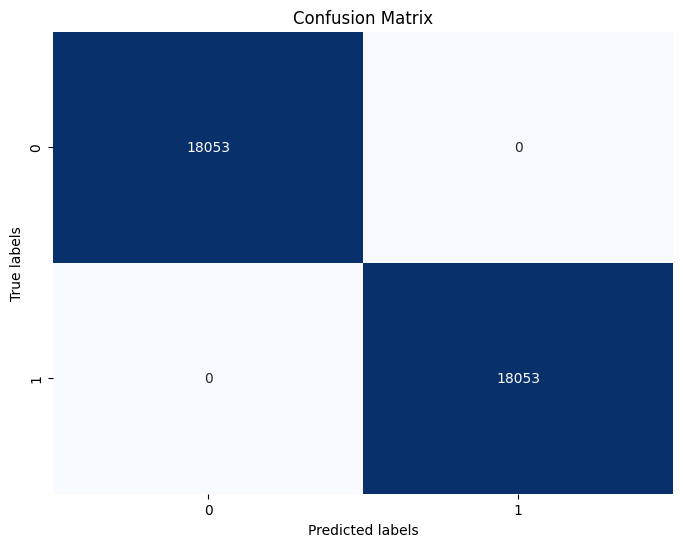

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC: 1.0
Confusion Matrix:
 [[18053     0]
 [    0 18053]]
F1 Score: 1.0
Training time: 0.6826984882354736
Inference time: 0.14650464057922363


In [12]:
# ==============================================
# == Segment 3: # Building and fit the classifier
# ==============================================

def SVM_Model(X_train_transformed,y_train,X_test_transformed,y_test):
    #Import svm model
    from sklearn import svm
    # Create SVM Classifier with current kernel
    clf = svm.SVC(kernel='linear', gamma=1, C=0.1)
    # Start training time measurement
    start_train_time = time.time()
    # Train the model
    # Perform cross-validation
    clf.fit(X_train_transformed, y_train)
    # End training time measurement
    end_train_time = time.time()
    # Predict the response for test dataset
    start_inference_time = time.time()
    y_pred = clf.predict(X_test_transformed)
    end_inference_time = time.time()
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred)
    # Print performance metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("AUC:", auc)
    print("Confusion Matrix:\n", cm)
    print("F1 Score:", f1)
    # Print training and inference times
    print("Training time:", end_train_time - start_train_time)
    print("Inference time:", end_inference_time - start_inference_time)
    # save the model to disk
    filename = 'finalized_model.sav'
    joblib.dump(clf, filename)

SVM_Model(X_train_transformed,y_train,X_test_transformed,y_test)